In [1]:
from fbprophet import Prophet
import fbprophet.diagnostics as Prophet_Diagnostics

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import pandas as pd
from datetime import datetime
import warnings
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import locale
warnings.filterwarnings('ignore')

from GridSearchProphet import GridSearch

# locale.setlocale(locale.LC_NUMERIC, "deu_deu")

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.formatter.use_locale'] = True

In [3]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Reading data

In [4]:
# reading data
evo_data = pd.read_csv('data/demand_datasets/evo_demand.csv', index_col=0)
modo_data = pd.read_csv('data/demand_datasets/modo_demand.csv', index_col=0)
c2g_data = pd.read_csv('data/demand_datasets/c2g_demand.csv', index_col=0)

In [5]:
#cleaning process
evo_data.index = pd.to_datetime(evo_data.index)
modo_data.index = pd.to_datetime(modo_data.index)
c2g_data.index = pd.to_datetime(c2g_data.index)

Selecting the period that has less missing data between the three services.

In [6]:
init_period = '06-23'
end_period = '07-12'

evo_data = evo_data[(evo_data.index >= '2018-'+init_period) & (evo_data.index <= '2018-'+end_period)]
modo_data = modo_data[(modo_data.index >= '2018-'+init_period) & (modo_data.index <= '2018-'+end_period)]
c2g_data = c2g_data[(c2g_data.index >= '2017-'+init_period) & (c2g_data.index <= '2017-'+end_period)]

Formating the data to the Prophet dataframe structure, where the timestamps stay in the ds collumn and the values in the y column.

In [7]:
def to_prophet_data(data):
    """
        Convert a time series list to the prophet data structure
    """
    prophet_data = pd.DataFrame(list(zip(data.index, data.travels)), columns=['ds','y'])
    prophet_data.sort_values(by='ds',inplace=True)
    prophet_data.reset_index(inplace=True, drop=True)
    
    return prophet_data

In [8]:
#prophet data structure

evo_prophet = to_prophet_data(evo_data)
modo_prophet = to_prophet_data(modo_data)
c2g_prophet = to_prophet_data(c2g_data)

In [9]:
evo_prophet.head()

,ds,y
0,2018-06-23 21:00:00,1
1,2018-06-24 10:00:00,1
2,2018-06-24 15:00:00,1
3,2018-06-24 19:00:00,1
4,2018-06-25 20:00:00,1


## Train data used

In [10]:
def plot_time_points(data):
    fig, ax = plt.subplots(1,1)
    
    ax.scatter(data.ds, data.y, alpha=0.3)

    ax.set_xlim(data.ds.min(), data.ds.max())
    plt.xticks(rotation=45)
    
    plt.show()

### EVO

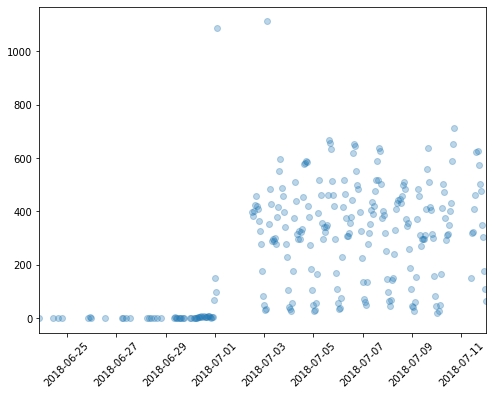

In [11]:
evo_z_scores = stats.zscore(evo_prophet.y)
abs_evo_z_scores = np.abs(evo_z_scores)
filtered_evo_entries = (abs_evo_z_scores < 4)
evo_filtered_prophet = evo_prophet[filtered_evo_entries].copy()
plot_time_points(evo_prophet)

### Modo

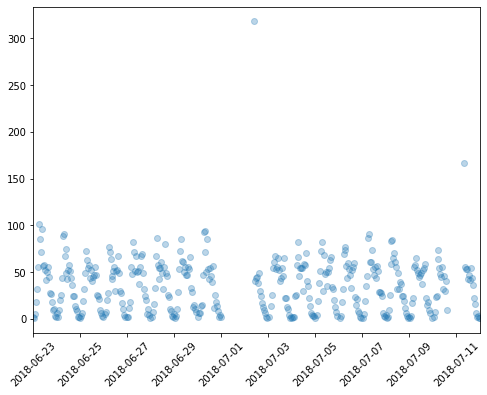

In [12]:
modo_z_scores = stats.zscore(modo_prophet.y)
abs_modo_z_scores = np.abs(modo_z_scores)
filtered_modo_entries = (abs_modo_z_scores < 4)
modo_filtered_prophet = modo_prophet[filtered_modo_entries].copy()
plot_time_points(modo_prophet)

### Car2Go

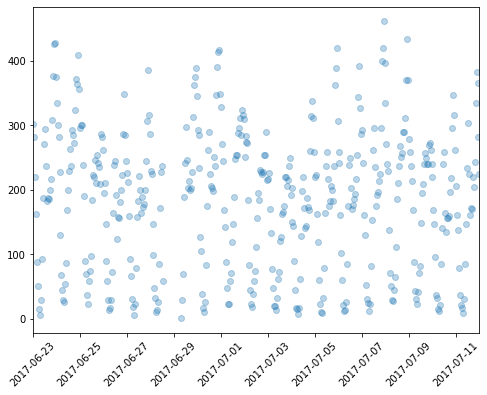

In [13]:
c2g_z_scores = stats.zscore(c2g_prophet.y)
abs_c2g_z_scores = np.abs(c2g_z_scores)
filtered_c2g_entries = (abs_c2g_z_scores < 4)
c2g_filtered_prophet = c2g_prophet[filtered_c2g_entries].copy()
plot_time_points(c2g_prophet)

## Normalizing Datasets

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


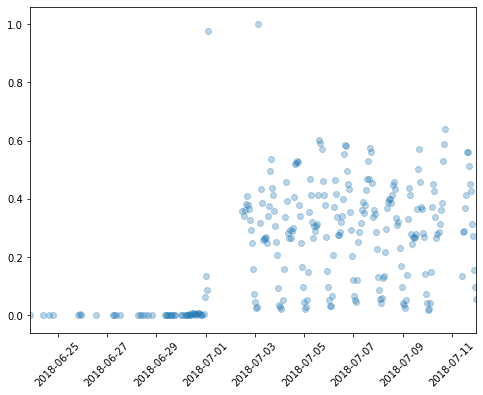

In [13]:
evo_filtered_prophet = evo_prophet
v_min = evo_filtered_prophet.y.min()
v_max = evo_filtered_prophet.y.max()
evo_filtered_prophet.y -= v_min
evo_filtered_prophet.y /= (v_max - v_min)
plot_time_points(evo_filtered_prophet)

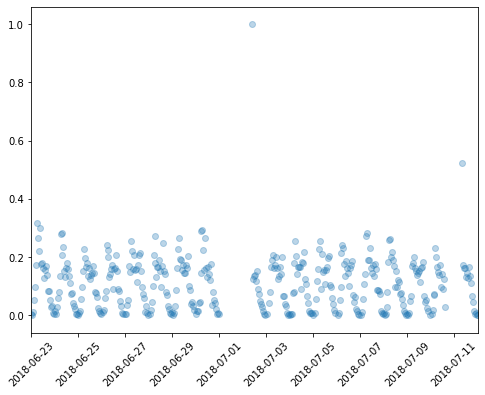

In [15]:
modo_filtered_prophet = modo_prophet
v_min = modo_filtered_prophet.y.min()
v_max = modo_filtered_prophet.y.max()
modo_filtered_prophet.y -= v_min
modo_filtered_prophet.y /= (v_max - v_min)
plot_time_points(modo_filtered_prophet)

In [16]:
v_min, v_max

(1, 318)

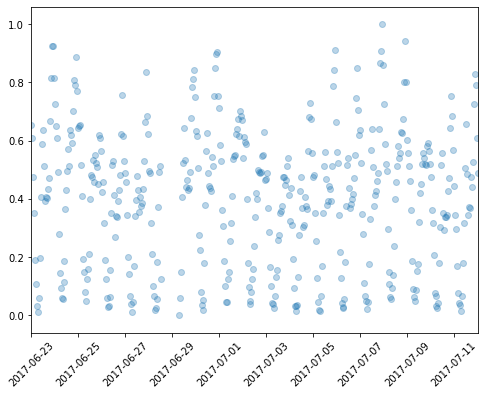

In [17]:
c2g_filtered_prophet = c2g_prophet
v_min = c2g_filtered_prophet.y.min()
v_max = c2g_filtered_prophet.y.max()
c2g_filtered_prophet.y -= v_min
c2g_filtered_prophet.y /= (v_max - v_min)
plot_time_points(c2g_filtered_prophet)

## Prophet forecast

During the selected periods there is a occurence of the Canada Day, so him will be included as parameters to the models.

In [14]:
holidays = pd.DataFrame({
  'holiday': 'Canada_day',
  'ds': pd.to_datetime(['2017-07-01','2018-07-02']),
  'lower_window': 0,
  'upper_window': 1,
})

In [15]:
# splitting in train (80%) and test data (20%)
def split(data, perc=0.8):
    index = int(len(data)*0.8)
    return data[:index], data[index:]

evo_train, evo_test = split(evo_filtered_prophet)
# evo_norm_train, evo_norm_test = split(evo_filtered_prophet)

modo_train, modo_test = split(modo_filtered_prophet)
# modo_norm_train, modo_norm_test = split(modo_filtered_prophet)

c2g_train, c2g_test = split(c2g_filtered_prophet)
# c2g_norm_train, c2g_norm_test = split(c2g_filtered_prophet)

## Testing the models

Defining helper functions to create the model, plot the predictions, plot the learning curve of the models and eval the error metrics.

In [16]:
def prophet_predict(data, params, freq='H', periods=5):
    """
    Creates and fit the Prophet model give the data and parameters.
    """
    model = Prophet(**params)
    model.fit(data)
    
    future = model.make_future_dataframe(freq=freq, periods=periods)
    
    forecast = model.predict(future)
    
    return model, forecast

In [17]:
def plot_forecast(df, df_forecast, predict_period, savefile='', legend_font_size="medium",
                                    axis_value_size="medium", axis_label_size="medium"):
    """
    Plot the data with the fitted curve and predict a future period of data based on the same last period of the given data.
    """

    plt.figure(figsize=(30,10))
    plt.scatter(df.ds,df.y,c='black',s=8,label='Real Values')
    plt.plot(df_forecast.ds[:-predict_period], df_forecast.yhat[:-predict_period], label='Predicted Values')
    plt.fill_between(df_forecast.ds,df_forecast.yhat_upper,df_forecast.yhat_lower,
                     label='Uncertainty Interval',alpha=0.3)
    plt.plot(df_forecast.ds[-predict_period:], df_forecast.yhat[-predict_period:], label='Future Predicted Values',ls='--')

    plt.xlim(df_forecast.ds.min(), df_forecast.ds.max())
    plt.ylabel('Requested Travels per Hour', fontdict={"fontsize":axis_label_size})
    plt.xlabel('Hours', fontdict={"fontsize":axis_label_size})
    plt.legend(fontsize=legend_font_size, loc=1, borderaxespad=0.2, frameon=False)
    plt.tick_params(axis="both", labelsize=axis_value_size)
    plt.xticks(rotation=45)
    
    ax = plt.gca()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if savefile != '':
        plt.savefig(savefile, bbox_inches='tight')

    plt.show()

In [20]:
def eval_model(y, y_hat):
    """
    Return the error metrics obtained by the prediction of the y_hat.
    """
    
    evaluation = {}
    evaluation["rmse"] = np.sqrt(mean_squared_error(y, y_hat))
    evaluation["mse"] = mean_squared_error(y, y_hat)
    evaluation["mae"] = mean_absolute_error(y, y_hat)
    evaluation["r2"] = r2_score(y, y_hat)
    evaluation["mape"] = mape(y, y_hat)

    return evaluation

In [22]:
plot_styling = {
    "legend_font_size":36,
    "axis_value_size":32,
    "axis_label_size":34
}

In [23]:
# Period to be predicted by the models
PREDICT_PERIOD = 12  # 12 hours

#evo_model, evo_forecast = prophet_predict(evo_train, periods=PREDICT_PERIOD, params=evo_params)
evo_model, evo_forecast = prophet_predict(evo_train, periods=PREDICT_PERIOD, params={'holidays': holidays}, freq='H')

print('EVO done.')
# modo_model, modo_forecast = prophet_predict(modo_train, periods=PREDICT_PERIOD, params=modo_params)
modo_model, modo_forecast = prophet_predict(modo_train, periods=PREDICT_PERIOD, params={'holidays': holidays}, freq='H')
print('Modo done.')
c2g_model, c2g_forecast = prophet_predict(c2g_train, periods=PREDICT_PERIOD, params={'holidays': holidays}, freq='H')
# c2g_model, c2g_forecast = prophet_predict(c2g_train, periods=PREDICT_PERIOD, params=c2g_params)

print('Car2Go done.')

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


EVO done.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Modo done.
Car2Go done.


### EVO

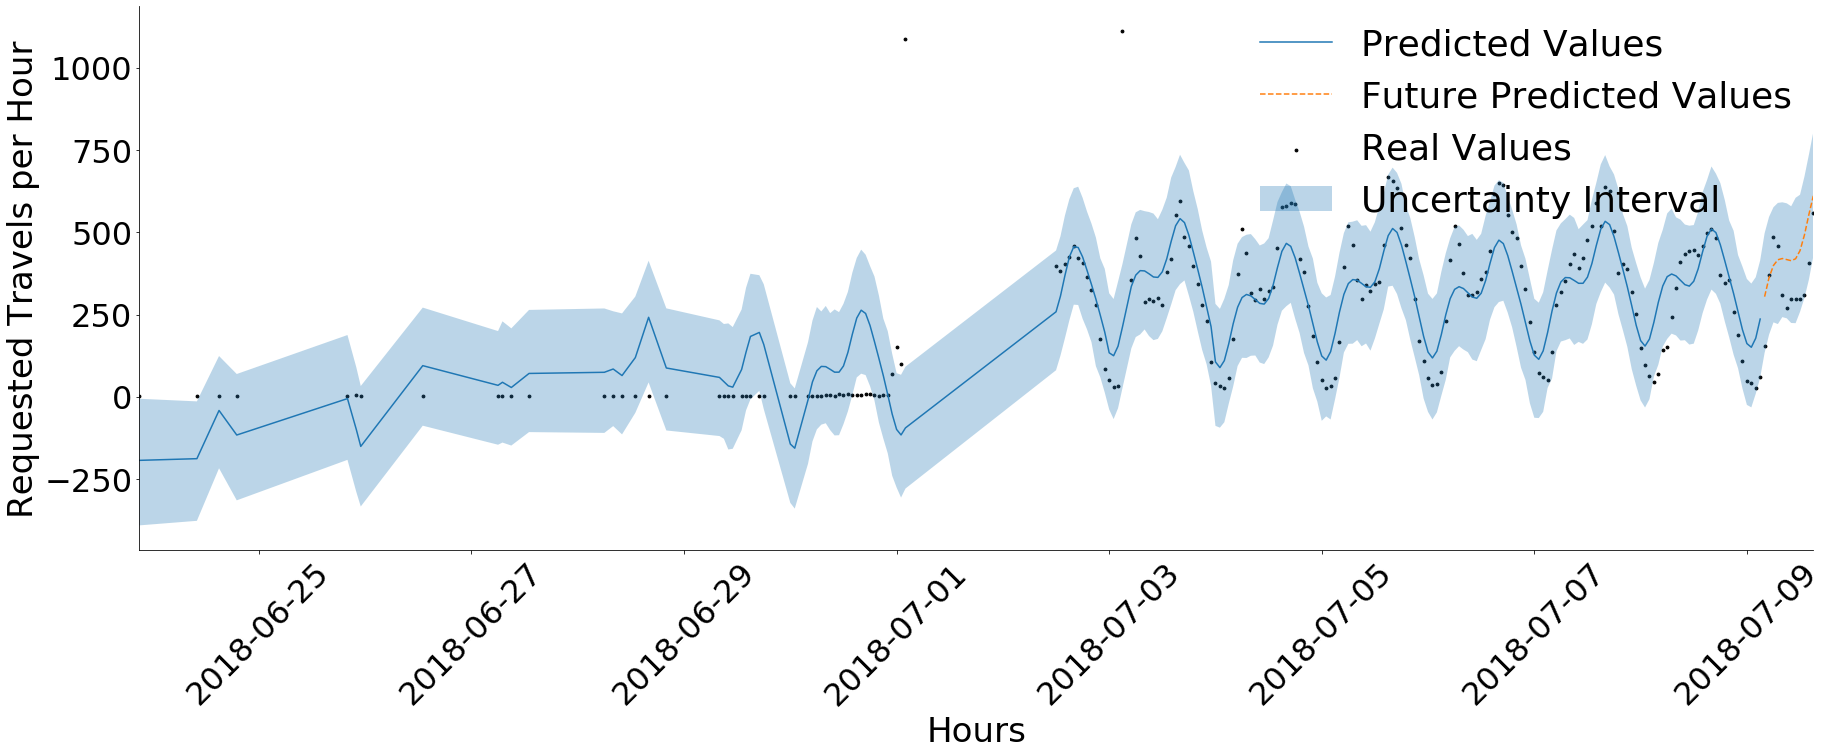

In [19]:
plot_forecast(evo_prophet, evo_forecast, PREDICT_PERIOD, **plot_styling, savefile='JISA/old_prophet/evo_predict.pdf')

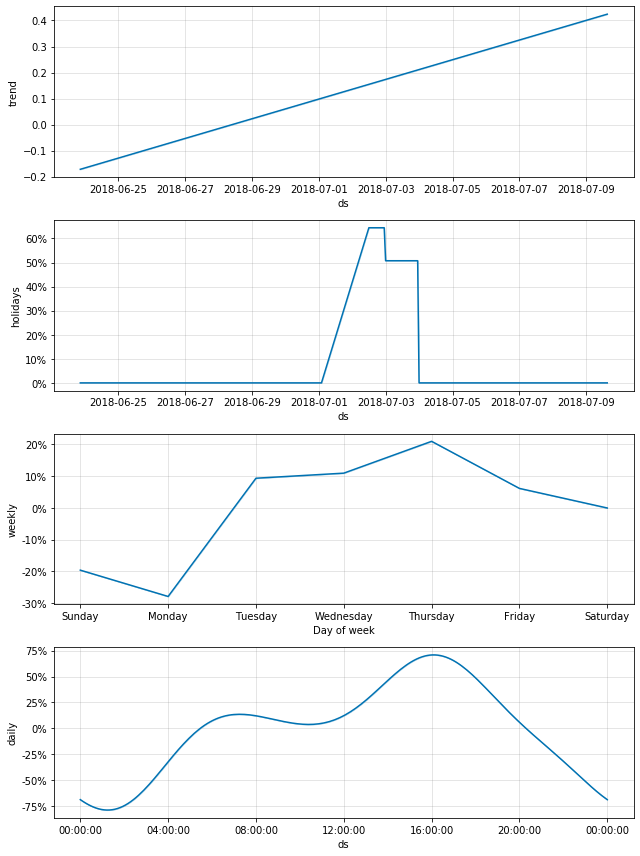

In [27]:
fig1 = evo_model.plot_components(evo_forecast)
plt.show()

#### Metrics

In [28]:
# test set
prediction = evo_model.predict(evo_test[['ds']])
print(eval_model(evo_test.y, prediction.yhat))

{'rmse': 215.35167064235486, 'mse': 46376.34204845328, 'mae': 193.02544247244256, 'r2': -0.539247558955904, 'mape': 152.00224474542142}


In [30]:
print('mean', np.mean(prediction.yhat))
print('std', np.std(prediction.yhat))

mean 539.368923485407
std 119.08618338829741


### Modo

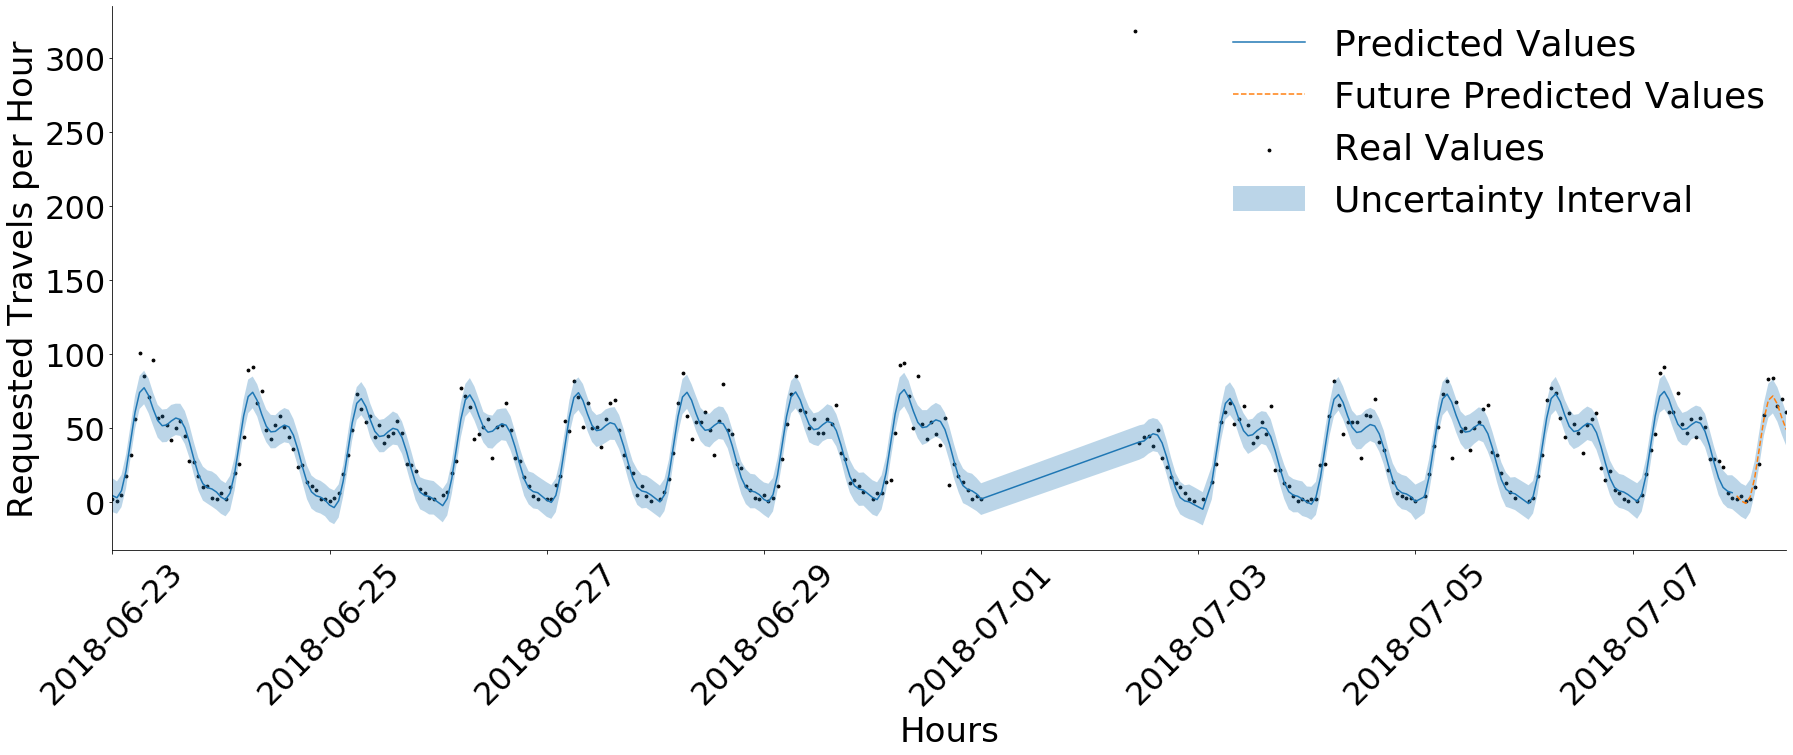

In [24]:
plot_forecast(modo_prophet, modo_forecast, PREDICT_PERIOD, **plot_styling, savefile='JISA/old_prophet/modo_predict.pdf')

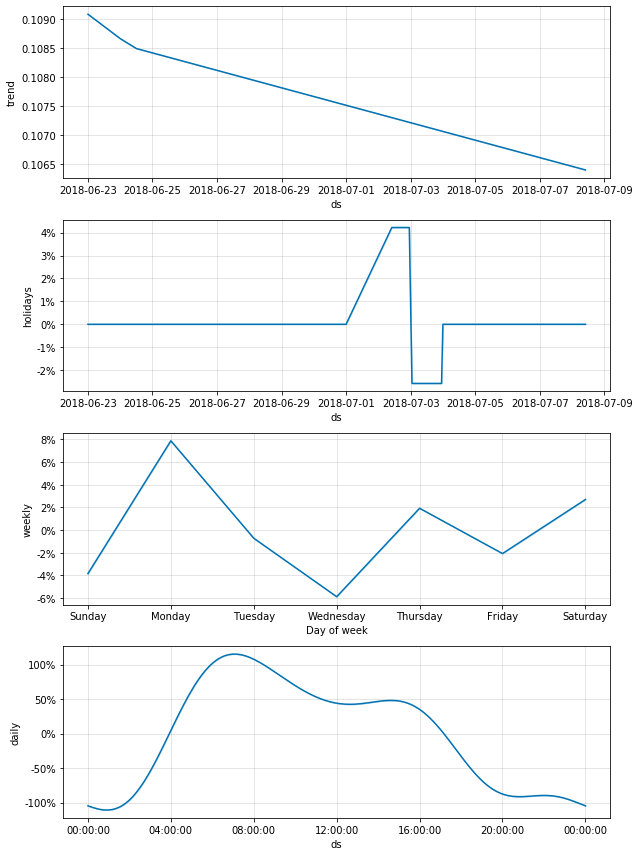

In [31]:
fig1 = modo_model.plot_components(modo_forecast)
plt.show()

In [31]:
# test set
prediction = modo_model.predict(modo_test[['ds']])
print(eval_model(modo_test.y, prediction.yhat))

{'rmse': 9.255800007231702, 'mse': 85.66983377387038, 'mae': 6.987489446801148, 'r2': 0.8408124560225357, 'mape': 61.82076142779655}


In [32]:
print('mean', np.mean(prediction.yhat))
print('std', np.std(prediction.yhat))

mean 33.11384418711294
std 23.471948423785445


### Car2Go

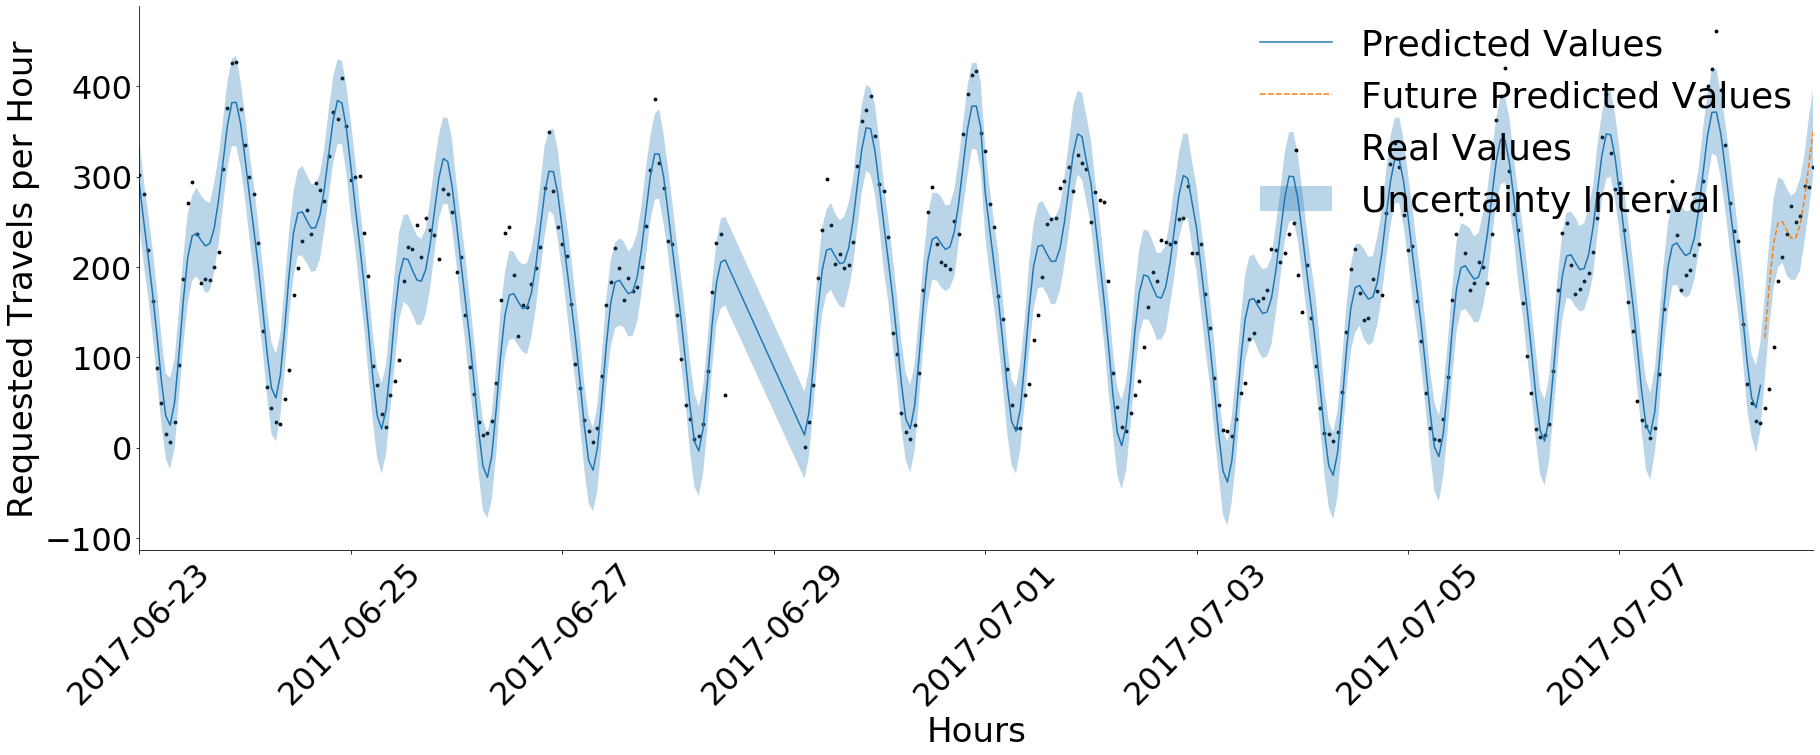

In [27]:
plot_forecast(c2g_prophet,c2g_forecast,PREDICT_PERIOD, **plot_styling, savefile='JISA/old_prophet/c2g_predict.pdf')

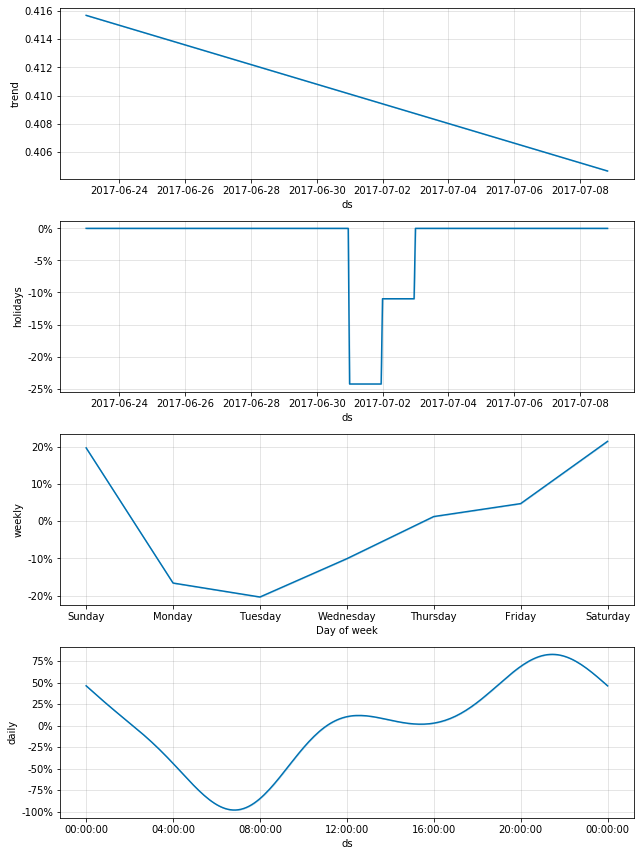

In [35]:
fig1 = c2g_model.plot_components(c2g_forecast)
plt.show()

In [34]:
prediction = c2g_model.predict(c2g_test[['ds']])
print(eval_model(c2g_test.y, prediction.yhat))

{'rmse': 46.163827853237464, 'mse': 2131.099002063343, 'mae': 35.91528528873762, 'r2': 0.7986088588900502, 'mape': 47.66909772009486}


In [35]:
print('mean', np.mean(prediction.yhat))
print('std', np.std(prediction.yhat))

mean 176.9745929618906
std 101.98291514090594
